In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [13]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)# x here is just a vector to be standardized (subtract mean and divide by std dev)
y, tx = build_model_data(x, weight) # tx here is a matrix of x and 1s (for intercept) where x here represents the feature matrix (DxN)

In [4]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function

## 1.1. Define the Cost Function

\begin{equation}
    MSE=\frac{1}{2N} \sum_{n=1}^{N} \underbrace{[y_n-x_n^Tw]^2}_{L_n(w) = e_n^2}
\end{equation}

\begin{equation}
    MAE=\frac{1}{N} \sum_{n=1}^{N} |y_n-x_n^Tw|
\end{equation}


In [19]:


def compute_loss(y, tx, w,method='mse'):

    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    e = y - tx.dot(w)
    if method == 'mse':
        return 1/2*np.mean(e**2)
    elif method == 'mae':
        return np.mean(abs(e))
        
    # ***************************************************

#compute_loss(weight,tx,np.array([1,2]),method='mse')
compute_loss(weight,tx,np.array([1,2]),method='mae')


72.29392200210518

# 2. Grid Search

Fill in the function `grid_search()` below:

In [24]:
# from costs import *

def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.
        
    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    for i, w0 in enumerate(grid_w0):
        for j, w1 in enumerate(grid_w1):
            losses[i,j] = compute_loss(y,tx,np.array([w0,w1]),method='mse')


    # ***************************************************
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=15.55870336860953, w0*=72.72727272727272, w1*=13.636363636363626, execution time=0.644 seconds


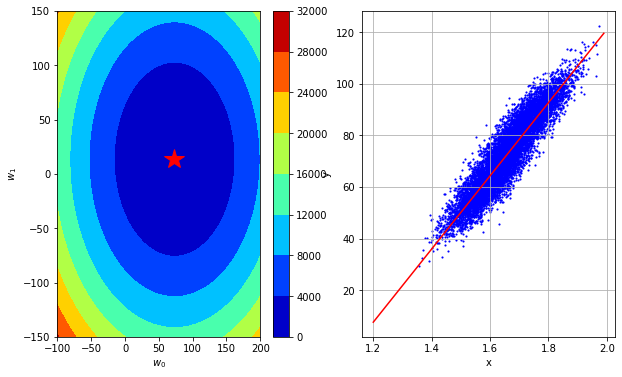

In [31]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=100)#Num of intervals at 10 results in bad results

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [45]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************

    # ***************************************************
    return -tx.T.dot(y-tx.dot(w))/len(y)

#compute_gradient(weight,tx,np.array([50,10]))
compute_gradient(weight,tx,np.array([100,20]))

array([26.706078  ,  6.52028757])

Please fill in the functions `gradient_descent` below:

In [40]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        gradient = compute_gradient(y,tx,w)
        loss = compute_loss(y,tx,w,method='mse')
        
        w = w - gamma*gradient  
        # ***************************************************
        # store w and loss    
        ws.append(w)
        losses.append(loss)
        print("GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws



Test your gradient descent function through gradient descent demo shown below:

In [89]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.2367127591674, w0=51.305745401473644, w1=9.435798704492269
GD iter. 1/49: loss=265.3024621089598, w0=66.69746902191571, w1=12.266538315840005
GD iter. 2/49: loss=37.87837955044126, w0=71.31498610804834, w1=13.115760199244333
GD iter. 3/49: loss=17.410212120174467, w0=72.70024123388814, w1=13.370526764265632
GD iter. 4/49: loss=15.568077051450455, w0=73.11581777164007, w1=13.446956733772023
GD iter. 5/49: loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=15.38736360120863, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/49: loss=15.38602068474353, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=15.385888944638305, w0=73.29348920882515, w1=13.47963283863509
GD iter. 10/49: loss=15.3858879656522, w0=73.29379216412117, w1=13.479688556082861
GD iter. 11/49: loss=15.385887877543452, w0=73.29388305070998, w1=13.47970527131719

In [59]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [109]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    stochastic_gradient = tx.T.dot(tx.dot(w) - y) * 1 / len(y) #So far exactly as standard gradient.
    # ***************************************************
    return stochastic_gradient

def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
        # Perform operations or computations on minibatch_y and minibatch_tx
            w = w - gamma * compute_stoch_gradient(minibatch_y,minibatch_tx,w)
            loss = compute_loss(minibatch_y,minibatch_tx,w,method='mse')
        # ***************************************************

        # store w and loss    
        ws.append(w)
        losses.append(loss)
        print("SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [110]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=444.8229598757935, w0=4.744178864218266, w1=-7.814140626270545
SGD iter. 1/49: loss=2134.7341460330067, w0=12.495114664945286, w1=-1.9628287715163548
SGD iter. 2/49: loss=394.50113074101984, w0=16.447020052327915, w1=-7.399023017551172
SGD iter. 3/49: loss=1260.8457793751104, w0=25.1780711427174, w1=8.337524034800264
SGD iter. 4/49: loss=1101.3052643596927, w0=30.46854527188305, w1=10.2374279452802
SGD iter. 5/49: loss=493.733042738276, w0=33.96190165608948, w1=10.475571584349092
SGD iter. 6/49: loss=955.6117805961663, w0=38.93539370998376, w1=12.754114196651905
SGD iter. 7/49: loss=537.4400034846892, w0=42.64608926276296, w1=11.2485067364227
SGD iter. 8/49: loss=568.6459336006828, w0=46.39319083098482, w1=11.224336057250204
SGD iter. 9/49: loss=181.46820348122455, w0=48.72092216320928, w1=9.122040880952694
SGD iter. 10/49: loss=209.82128507622707, w0=51.00221967759093, w1=9.447734859936896
SGD iter. 11/49: loss=420.82399872025155, w0=54.484163154857, w1=6.60166414

In [111]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [136]:
import datetime
from helpers import *

# Load data bs sub-sampling and outliers
height, weight, gender = load_data(sub_sample=True, add_outlier=True)

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [137]:
y.shape, tx.shape

((202,), (202, 2))

In [139]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points 
#       and the model fit
ws = [w_initial]
w = w_initial
losses = []
for n_iter in range(max_iters):
    gradient = compute_gradient(y,tx,w)
    loss = compute_loss(y,tx,w,method='mae')
    w = w - gamma*gradient  
    ws.append(w)
    losses.append(loss)
    print("GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
          bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
# ***************************************************


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=74.06780585492638, w0=51.84746409844842, w1=7.7244264061924195
GD iter. 1/49: loss=22.22034175647795, w0=67.40170332798297, w1=10.041754328050114
GD iter. 2/49: loss=8.540676439415359, w0=72.06797509684336, w1=10.736952704607411
GD iter. 3/49: loss=6.90482836681024, w0=73.46785662750146, w1=10.945512217574597
GD iter. 4/49: loss=6.674709716875213, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=6.644814813344382, w0=74.01381042445813, w1=11.026850427631798
GD iter. 6/49: loss=6.639117501635083, w0=74.0516072257859, w1=11.032481534481914
GD iter. 7/49: loss=6.63780292636886, w0=74.06294626618423, w1=11.034170866536945
GD iter. 8/49: loss=6.6375033908412755, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=6.637417848906233, w0=74.06736849193958, w1=11.034829706038408
GD iter. 10/49: loss=6.637392186325722, w0=74.06767464603033, w1=11.034875318003895
GD iter. 11/49: loss=6.637384487551567, w0=74.06776649225755, w1=11.034889001593541
GD it

In [140]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [ ]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute subgradient gradient vector for MAE
    # ***************************************************
    raise NotImplementedError

In [ ]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        raise NotImplementedError
        
        ws.append(w)
        losses.append(loss)
        print("SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(
    y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses, subgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [ ]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):

        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        raise NotImplementedError
        
        print("SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses, subsgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))